# Self-synteny for WGD detection

If a whole-genome duplication (WGD) has happened in a lineage, we would expect to see at least some
corresponding chromosomes that carry multiple paralogous genes. Therefore, if we perform an
all-against-all search with protein sequences, set a relatively high e-value threshold (e.g.
$10^{-10}$ or $10^{-20}$) and exclude self-hits (i.e. search for paralogs), we should be able to see
a pattern. If WGD has taken place, we should be seeing many clustered off-diagonal hits, linking the
two paralogous chromosomes. However, if all that is seen is a random scatter of hits, then it is
likely that no WGD has occurred.

used this list to scan against the _P. litorale_ draft genome using `mmseqs`:

```bash
cd /lisc/scratch/zoology/pycnogonum/genome/draft/self_synteny
module load mmseqs2
M8FORMAT="query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qlen"
proteome=/lisc/scratch/zoology/pycnogonum/genome/draft/transcripts.fa.transdecoder.pep
mmseqs easy-search $proteome $proteome self.m8 tmp --format-output $M8FORMAT --threads 16 --cov-mode 5 -c 0.8
```

For coverage mode, we compare the length of the shorter sequence to the longer one, and we ask that
at least 80% of the longer sequence is covered. This is because we are specifically looking for
paralogs, and we expect that duplicated genes should have roughly the same length.

We will need numpy and pandas for data wrangling, and matplotlib for plotting.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

Some preparation first:

In [2]:
# we will need to read in the GFF file, because it holds the gene names and positions.
def read_gff(loc):
    gff = pd.read_csv(loc, sep="\t", header=None, skiprows=4)
    gff_columns = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    gff.columns = gff_columns
    return gff

# the alignment file is similar to the BLAST tabular format, but we defined the columns in the
# `M8FORMAT` variable.
def read_aln(m8, id_sep=None):
    plit = pd.read_csv(m8, sep="\t", header=None)
    m8_columns = ['query', 'target', 'seq_id', 'ali_len', 'no_mism', 'no_go',
                'q_start', 'q_end', 't_start', 't_end', 'eval', 'bit', 'qlen']
    plit.columns = m8_columns
    # trim the query to just the ID
    if id_sep is not None:
        plit["query"] = plit["query"].str.split(id_sep).str[1]
    return plit

# in order to get the offsets right in the Oxford grid later, we need to know the length of all the
# chromosomes, hence we need to read the FASTA file.
def get_contig_lengths(fasta):
    lengths = {}
    with open(fasta, "r") as fh:
        for line in fh:
            if line.startswith(">"):
                contig = line.strip().split()[0].replace(">", "")
                lengths[contig] = 0
            else:
                lengths[contig] += len(line.strip())
    return lengths

# MMseqs2 takes the proteome as input; gene names will contain the transcript and protein IDs, so we
# need to remove those.
def extract_gene_name(x):
    if x.startswith("PB"):
        return ".".join(x.split(".")[0:2]).split(',')[0]
    elif x.startswith("g"):
        return x.split(".")[0]
    elif x.startswith("r2"):
        return x.split(".")[0]
    elif x.startswith("at"):
        return x.split(".")[0]
    else:
        return None

Read and parse the GFF file. Gene names should now be in a separate column.

In [3]:
gff_loc = "/Volumes/project/pycnogonum/paper/zenodo/results/merged_sorted_named_dedup_flagged.gff3"
fasta_loc = "/Volumes/project/pycnogonum/paper/zenodo/results/draft.fasta"

tmp = read_gff(gff_loc)
gff = tmp[tmp['type'] == 'gene'].copy()
gff['gene'] = gff['attributes'].str.split("ID=").str[1].str.split(";").str[0]
gff['gene'] = gff['gene'].str.split(',').str[0]
gff.set_index("gene", inplace=True)
del tmp

Parse the FASTA file to get the contig lengths:

In [5]:
contigs = get_contig_lengths(fasta_loc)

Read the alignment results, extract the gene names, and remove self-hits:

In [6]:
plit = read_aln('/Volumes/scratch/pycnogonum/genome/draft/self_synteny/self.m8')

plit['gene_from'] = plit['query'].apply(extract_gene_name)
plit['gene_to'] = plit['target'].apply(extract_gene_name)

remove = plit['gene_from'] == plit['gene_to']

The table is 

In [7]:
best = plit[~remove].groupby(['gene_from', 'gene_to'])['eval'].min().reset_index()

In [8]:
chromosomes = {x: contigs[x] for x in contigs.keys() if x.startswith("pseudochrom")}

offsets = {}
offsets["pseudochrom_1"] = 0

for i in np.arange(2, 58):
    offsets[f"pseudochrom_{i}"] = 0
    for j in np.arange(1, i):
        offsets[f"pseudochrom_{i}"] += contigs[f"pseudochrom_{j}"]

In [9]:
def calc_coordinates(row, gff, offsets):
    gene_from = row['gene_from']
    gene_to = row['gene_to']

    # get the chromosome for each gene
    chrom_from = gff['seqid'].loc[gene_from]
    chrom_to = gff['seqid'].loc[gene_to]

    # if either gene is on a scaffold, skip, we are not plotting those
    if chrom_from.startswith('scaffold') or chrom_to.startswith('scaffold'):
        return
    # if the genes are on the same chromosome, color them differently
    if chrom_from == chrom_to:
        col = 'red'
    else:
        col = 'darkgray'
    
    # get the middle of each gene
    start_from = gff['start'].loc[gene_from]
    end_from = gff['end'].loc[gene_from]
    loc_from = (start_from + end_from) / 2

    start_to = gff['start'].loc[gene_to]
    end_to = gff['end'].loc[gene_to]
    loc_to = (start_to + end_to) / 2

    # get the offset for each gene
    offset_from = offsets[chrom_from]
    offset_to = offsets[chrom_to]

    # plot the points
    y = loc_from + offset_from
    x = loc_to + offset_to

    # print(row['gene_from'], row['gene_to'], x, y)
    return x, y, col

In [10]:
tmp = best.apply(calc_coordinates, axis=1, gff=gff, offsets=offsets)
coordinates = pd.DataFrame(tmp.tolist(), columns=['x', 'y', 'col'])
best = best.join(coordinates)
best.dropna(inplace=True)
del tmp

In [11]:
total_length = sum([x for x in chromosomes.values()])

<Axes: xlabel='x', ylabel='y'>

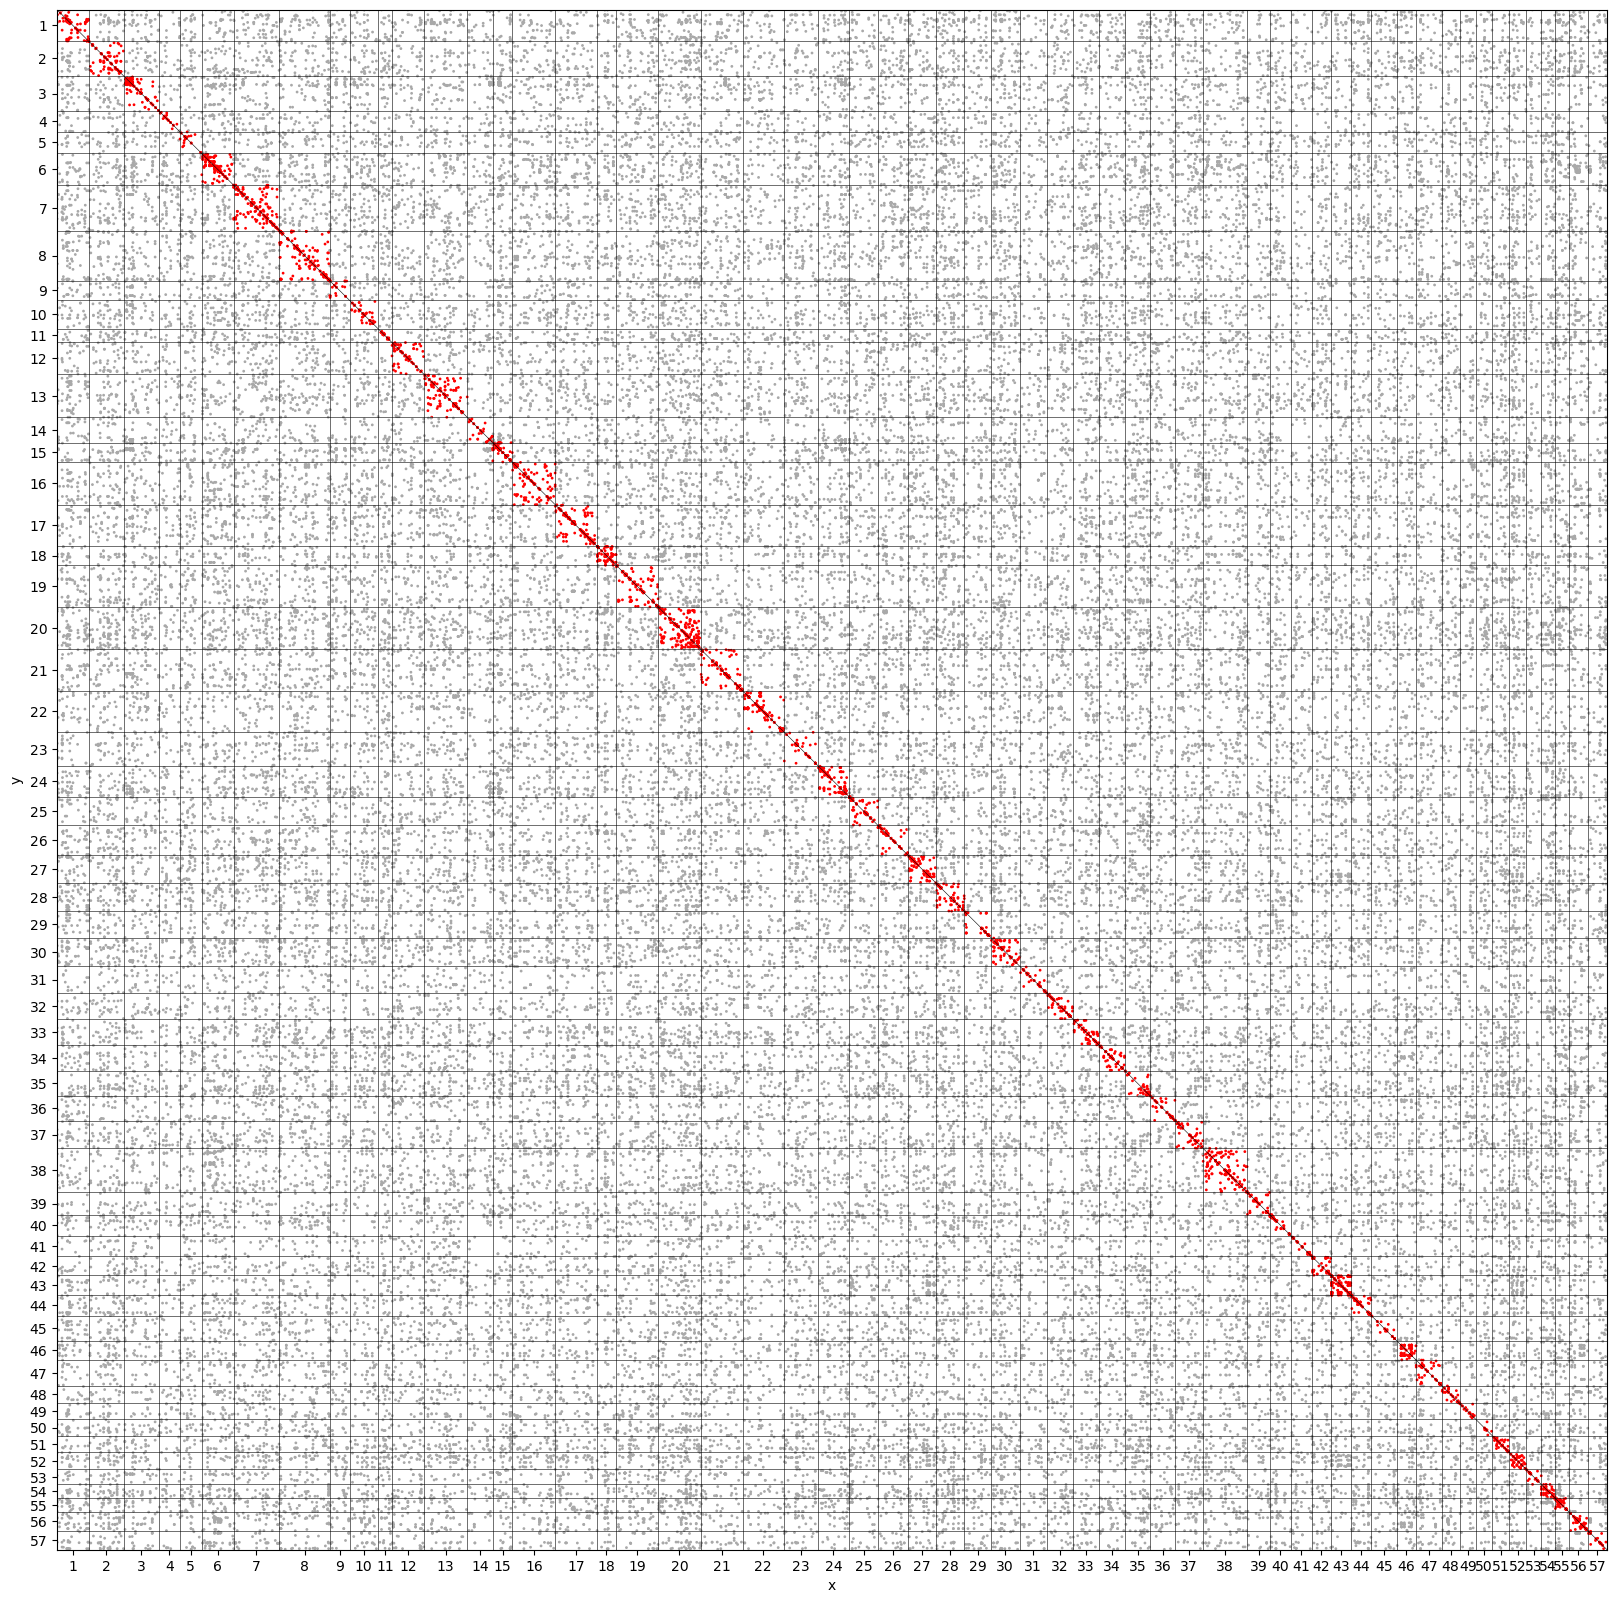

In [13]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.set_xlim(0, total_length)
ax.set_ylim(0, total_length)
ax.set_xticks([offsets[x]+chromosomes[x]/2 for x in chromosomes.keys()])
ax.set_xticklabels([x.split('_')[1] for x in chromosomes.keys()])

ax.set_yticks([offsets[x]+chromosomes[x]/2 for x in chromosomes.keys()])
ax.set_yticklabels([x.split('_')[1] for x in chromosomes.keys()])

ax.yaxis.set_inverted(True)

ax.plot([0, total_length], [0, total_length], color='black', linestyle='-', linewidth=0.4)

for _, offset in offsets.items():
    ax.axvline(offset, color='black', linewidth=0.4)
    ax.axhline(offset, color='black', linewidth=0.4)

keep = best['eval'] < 1e-5
best[keep].plot.scatter(x='x', y='y', c='col', ax=ax, s=1)